# Unit 5 - Financial Planning


In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
from datetime import date

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv('api_keys.env')

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btc_response = requests.get(btc_url)
btc_data = btc_response.json()
btc_price = btc_data['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_response = requests.get(eth_url)
eth_data = eth_response.json()
eth_price = eth_data['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $70378.80
The current value of your 5.3 ETH is $10053.15


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [23]:
# Format current date as ISO format
today = pd.Timestamp('2021-03-30', tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
df_portfolio = api.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today
).df

# Preview DataFrame
df_portfolio.head()

AGG                                       SPY  \
                             open    high      low   close   volume    open   
time                                                                          
2021-03-30 00:00:00-04:00  113.64  113.85  113.525  113.82  4742520  394.42   

                                                             
                             high     low   close    volume  
time                                                         
2021-03-30 00:00:00-04:00  395.45  393.02  394.78  63446300

In [21]:
# Pick AGG and SPY close prices
agg_close_price = df_portfolio.iloc[0][3]
spy_close_price = df_portfolio.iloc[0][8]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $113.82
Current SPY closing price: $394.78


In [22]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19739.00
The current value of your 200 AGG shares is $22764.00


### Savings Health Analysis

In [24]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
df_savings = pd.DataFrame({"amount":[my_btc_value+my_eth_value,my_spy_value+my_agg_value]})
df_savings.index = ['crypto','shares']

# Display savings DataFrame
display(df_savings)

,amount
crypto,80431.946
shares,42503.000


<AxesSubplot:ylabel='amount'>

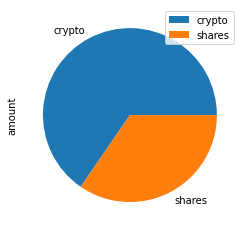

In [25]:
# Plot savings pie chart
df_savings.plot.pie(y='amount')

In [26]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amount'].sum()

# Validate saving health
if total_savings > emergency_fund:
    print('Congratulations you have enough money in your fund!')
elif total_savings == emergency_fund:
    print('Congratulations on reaching your goal!')
elif total_savings < emergency_fund:
    print(f'You are ${emergency_fund-total_savings} away from reaching the goal')

Congratulations you have enough money in your fund!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [27]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-03-30', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-03-30', tz='America/New_York').isoformat()

In [31]:
# Get 5 years' worth of historical data for SPY and AGG
tickers = ['SPY', 'AGG']
df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

# Display sample data
df_stock_data.head()

AGG                                       \
                             open    high       low   close     volume   
time                                                                     
2017-04-07 00:00:00-04:00  108.80  108.89  108.4200  108.44  1668826.0   
2017-04-10 00:00:00-04:00  108.53  108.65  108.4901  108.57  1751500.0   
2017-04-11 00:00:00-04:00  108.76  108.98  108.7500  108.90  2054745.0   
2017-04-12 00:00:00-04:00  108.93  109.20  108.8900  109.14  2243678.0   
2017-04-13 00:00:00-04:00  109.25  109.39  109.1300  109.28  2004878.0   

                              SPY                                       
                             open     high     low   close      volume  
time                                                                    
2017-04-07 00:00:00-04:00     NaN      NaN     NaN     NaN         NaN  
2017-04-10 00:00:00-04:00  235.36  236.255  234.73  235.32  46610548.0  
2017-04-11 00:00:00-04:00  234.87  235.180  233.34  235.04  63951745.0  
2017-04-12 00:00:00-04:00  234.74  234.960  233.77  234.10  55338215.0  
2017-04-13 00:00:00-04:00  233.63  234.490  232.54  232.54  63216959.0

In [37]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
#Set number of simulations
num_sims = 500

# Configure a Monte Carlo simulation to forecast three years daily returns
MC_thirty_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4,0.6],
    num_simulation = num_sims,
    num_trading_days = 252 * 30
)

In [42]:
# Printing the simulation input data
df_stock_data.head()

AGG                                       \
                             open    high       low   close     volume   
time                                                                     
2017-04-07 00:00:00-04:00  108.80  108.89  108.4200  108.44  1668826.0   
2017-04-10 00:00:00-04:00  108.53  108.65  108.4901  108.57  1751500.0   
2017-04-11 00:00:00-04:00  108.76  108.98  108.7500  108.90  2054745.0   
2017-04-12 00:00:00-04:00  108.93  109.20  108.8900  109.14  2243678.0   
2017-04-13 00:00:00-04:00  109.25  109.39  109.1300  109.28  2004878.0   

                              SPY                                       
                             open     high     low   close      volume  
time                                                                    
2017-04-07 00:00:00-04:00     NaN      NaN     NaN     NaN         NaN  
2017-04-10 00:00:00-04:00  235.36  236.255  234.73  235.32  46610548.0  
2017-04-11 00:00:00-04:00  234.87  235.180  233.34  235.04  63951745.0  
2017-04-12 00:00:00-04:00  234.74  234.960  233.77  234.10  55338215.0  
2017-04-13 00:00:00-04:00  233.63  234.490  232.54  232.54  63216959.0

In [43]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993603,0.990439,1.022075,0.999392,1.008382,1.011813,0.988998,1.004133,0.998207,1.009490,...,1.007635,1.004183,0.994369,1.005556,1.000142,0.998693,1.015981,1.008520,1.004688,1.011858
2,0.981119,1.003615,1.033712,1.003474,1.006138,1.006338,0.983278,1.008983,0.988035,1.003661,...,1.003968,1.009505,0.997282,1.012244,0.991130,1.005688,1.005047,1.005333,0.994392,1.015496
3,0.972198,1.012310,1.031481,1.004125,1.015652,1.008919,0.982910,1.013383,0.991102,1.005157,...,1.015754,1.009878,1.007008,1.016600,0.982012,0.998038,1.011625,1.006238,0.994815,1.020109
4,0.980765,1.010384,1.041182,1.007969,1.021323,1.009368,0.975248,1.018426,0.998230,1.015539,...,1.012203,1.015365,1.005264,1.004563,0.979995,0.992927,1.007872,0.993856,0.990955,1.027532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,36.575030,8.179522,13.671274,17.788477,34.320453,19.987830,12.809107,30.327885,15.702375,14.514040,...,28.095110,16.370970,5.252518,21.622752,10.690053,22.804970,9.469704,12.718704,21.742116,5.109753
7557,36.576276,8.180029,13.385589,17.776433,34.337987,19.807039,12.866021,30.285372,15.712792,14.705012,...,27.873795,16.367828,5.226668,21.546991,10.691269,22.917635,9.418559,12.456057,21.543481,5.127830
7558,36.526761,8.100614,13.430557,17.548891,34.138553,19.682582,12.992057,30.325713,15.751905,14.601085,...,28.144029,16.500518,5.193051,21.458290,10.690206,22.900176,9.500190,12.408475,21.566747,5.157799
7559,36.102008,8.129448,13.619943,17.743472,33.926551,19.621225,13.127908,30.290738,15.781159,14.522340,...,28.372444,16.593061,5.194743,21.522022,10.641323,22.763593,9.461902,12.355278,21.525679,5.140816


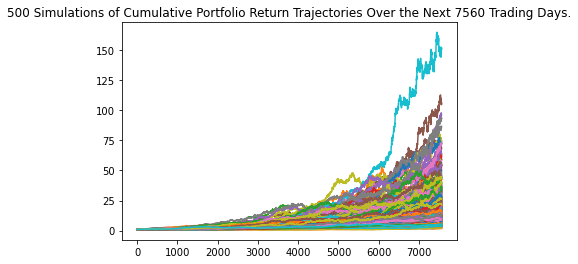

In [44]:
# Plot simulation outcomes
line_plot = MC_thirty_year.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_thirty_year_sim_plot.png", bbox_inches="tight")

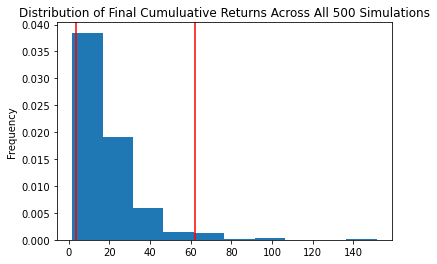

In [45]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirty_year.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_thirty_year_dist_plot.png',bbox_inches='tight')

### Retirement Analysis

In [46]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_thirty_year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean             18.736717
std              15.664646
min               1.649683
25%               9.111860
50%              14.205243
75%              22.784944
max             151.341443
95% CI Lower      3.673920
95% CI Upper     62.080692
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [47]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $73478.39 and $1241613.85


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [48]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $110217.59 and $1862420.77


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [91]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# Set number of simulations
num_sims = 500

# Configure a Monte Carlo simulation to forecast three years daily returns
MC_five_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.3,0.7],
    num_simulation = num_sims,
    num_trading_days = 252 * 5
)

In [92]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996687,0.999257,1.013029,1.000868,1.008643,0.979502,1.008803,0.993422,1.001274,0.999539,...,0.990993,1.003570,1.009476,0.991095,0.979938,0.983043,0.994789,0.997868,0.987815,1.006152
2,0.967659,0.988981,1.014169,1.011103,1.004928,0.984667,1.024407,1.006355,1.006176,1.003510,...,1.005174,1.003784,1.014726,0.994690,0.986013,0.991394,0.988024,1.005537,0.965004,0.995646
3,0.958728,0.981302,1.019891,0.993119,0.997804,0.976878,1.025004,1.010054,1.006010,1.003463,...,0.993126,1.000771,1.018844,0.980161,0.988949,0.988492,1.004396,0.998738,0.975189,0.996019
4,0.964370,0.986903,1.032164,0.986389,0.999407,0.974591,1.053740,1.015592,0.977916,1.010868,...,0.999559,0.991903,1.029956,0.982334,0.988208,0.990895,1.003764,0.995275,0.979285,0.985423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.712472,1.309271,1.306827,3.319340,4.151756,1.389242,1.828368,1.851472,1.558817,3.303213,...,0.938503,1.355261,1.880419,1.669338,3.036673,1.369598,1.487973,1.441742,1.541637,1.806652
1257,1.711748,1.311523,1.318217,3.325248,4.088411,1.401040,1.821533,1.863194,1.548257,3.276380,...,0.941156,1.366369,1.902390,1.664827,3.013390,1.379477,1.493342,1.422789,1.526868,1.828841
1258,1.722621,1.318904,1.316383,3.362156,4.123709,1.394215,1.826368,1.868349,1.561317,3.265589,...,0.947817,1.371666,1.906252,1.651619,2.991014,1.382064,1.517678,1.416137,1.534649,1.832056
1259,1.712704,1.315543,1.319730,3.298579,4.137240,1.372141,1.854879,1.876089,1.564349,3.298992,...,0.956944,1.349878,1.930221,1.655266,2.986080,1.387274,1.514096,1.423844,1.528725,1.828036


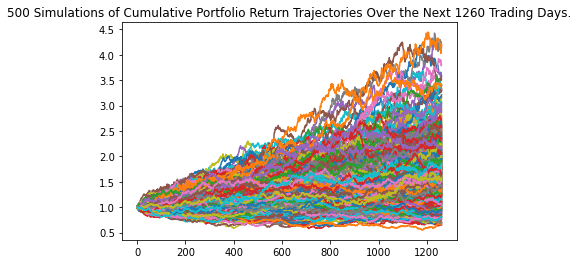

In [93]:
# Plot simulation outcomes
line_plot = MC_five_year.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_five_year_sim_plot.png", bbox_inches="tight")

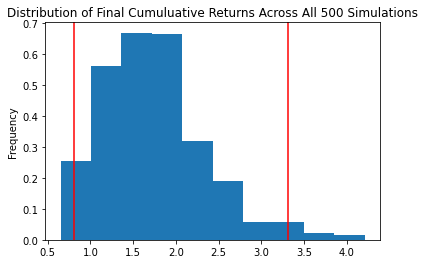

In [94]:
# Plot probability distribution and confidence intervals
dist_plot = MC_five_year.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_five_year_dist_plot.png',bbox_inches='tight')

In [95]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_five_year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              1.737498
std               0.608919
min               0.649766
25%               1.318332
50%               1.678344
75%               2.030833
max               4.209690
95% CI Lower      0.810114
95% CI Upper      3.307725
Name: 1260, dtype: float64


In [97]:
# Set initial investment
initial_investment = 20000 * 5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower_five = round(tbl[8]*initial_investment,2)
ci_upper_five = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $100000 in the portfolio over the next 5 years will end within in the range of $81011.39 and $330772.48


### Ten Years Retirement Option

In [98]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.3,0.7],
    num_simulation = num_sims,
    num_trading_days = 252 * 10
)

In [99]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998889,0.994917,1.007205,1.003489,0.991957,0.995672,0.996542,1.008489,0.997769,1.012741,...,0.985937,1.009230,1.001732,1.002382,1.000734,1.000390,0.998216,1.006061,1.006787,1.002458
2,0.986864,0.989852,1.006830,0.997406,0.996684,1.001034,0.990210,1.013716,1.015744,1.025116,...,0.982641,1.004503,1.011132,0.990620,0.999697,1.002269,0.991389,1.038931,0.998495,1.001106
3,0.972303,0.993028,1.004754,0.991417,1.006469,0.994909,0.988658,1.006356,1.020844,1.012095,...,0.990107,1.003473,1.018414,0.992342,1.006322,1.004368,0.984350,1.045272,0.989671,0.998064
4,0.977466,0.995640,0.998687,0.989691,1.004496,1.001795,0.971252,0.998523,1.029769,1.016433,...,0.993125,1.011651,1.029736,0.991218,1.000519,0.993167,0.988749,1.040715,0.985670,0.995769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.705773,3.049833,1.359321,9.396198,5.287829,1.121911,1.289642,1.107637,1.959505,1.894278,...,4.251589,3.301120,4.322204,4.124526,1.786123,1.712139,3.257556,3.062497,7.452024,2.938870
2517,2.739803,3.069282,1.350070,9.487996,5.283491,1.116778,1.290338,1.103563,1.948864,1.885391,...,4.222503,3.340549,4.366398,4.116017,1.765409,1.694467,3.230968,3.044152,7.387262,2.992434
2518,2.730331,3.024363,1.359613,9.532057,5.385965,1.122997,1.288474,1.112575,1.940412,1.884863,...,4.220237,3.356676,4.441020,4.113944,1.766863,1.700201,3.217821,3.038517,7.376157,2.954780
2519,2.719923,2.973547,1.351400,9.589190,5.297665,1.105511,1.287725,1.096165,1.926188,1.868074,...,4.237724,3.384161,4.442189,4.149450,1.779904,1.694100,3.259324,3.047672,7.350226,2.996022


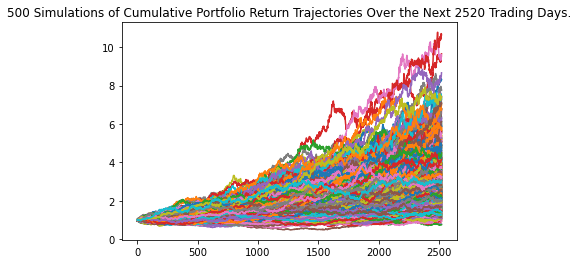

In [100]:
# Plot simulation outcomes
line_plot = MC_ten_year.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_ten_year_sim_plot.png", bbox_inches="tight")

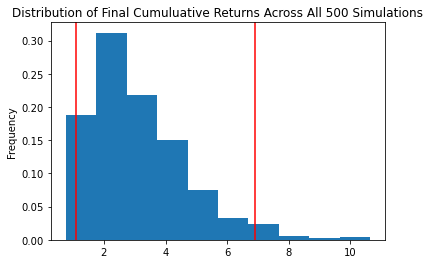

In [101]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ten_year.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_ten_year_dist_plot.png',bbox_inches='tight')

In [102]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_ten_year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              3.103376
std               1.542985
min               0.764827
25%               1.987961
50%               2.744728
75%               3.912359
max              10.638191
95% CI Lower      1.105765
95% CI Upper      6.898723
Name: 2520, dtype: float64


In [104]:
# Set initial investment
initial_investment = 20000 * 5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower_ten = round(tbl[8]*initial_investment,2)
ci_upper_ten = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $100000 in the portfolio over the next 10 years will end within in the range of $110576.51 and $689872.28
